# script to do experiments described in paper: Deep Interest Evolution Network for Click-Through Rate Prediction

## how to run

1. Please run prepare_neg.ipynb first.

In [7]:
SEQ_MAX_LEN = 100 # maximum sequence length
BATCH_SIZE = 128
EMBEDDING_DIM = 18
DNN_HIDDEN_SIZE = [200, 80]
DNN_DROPOUT = 0.0
TEST_RUN = False
EPOCH = 2
SEED = 10

In [5]:
%matplotlib inline

import itertools
from collections import Counter, OrderedDict

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from prediction_flow.features import Number, Category, Sequence, Features
from prediction_flow.transformers.column import (
    StandardScaler, CategoryEncoder, SequenceEncoder)

from prediction_flow.pytorch.data import Dataset
from prediction_flow.pytorch import WideDeep, DeepFM, DNN, DIN, DIEN, AttentionGroup

from prediction_flow.pytorch.functions import fit, predict, create_dataloader_fn

In [8]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [9]:
train_df = pd.read_csv(
    "./local_train.csv", sep='\t')

valid_df = pd.read_csv(
    "./local_test.csv", sep='\t')

In [10]:
if TEST_RUN:
    train_df = train_df.sample(1000)
    valid_df = valid_df.sample(1000)

In [11]:
train_df.head()

,label,uid,mid,cat,hist_mids,hist_cats,neg_hist_mids,neg_hist_cats
0,0,AZPJ9LUT0FEPY,B00AMNNTIA,Literature & Fiction,030774443400622483910470530707097892462215...,BooksBooksBooksBooksBooks,1449710247081098416406156331290962121940B0...,BooksBooksBooksBooksLiterature & Fiction
1,1,AZPJ9LUT0FEPY,0800731603,Books,030774443400622483910470530707097892462215...,BooksBooksBooksBooksBooks,014101761907369216800425258203160140462X14...,BooksBooksBooksBooksBooks
2,0,A2NRV79GKAU726,B003NNV10O,Russian,0814472869007146207415839423000812538366B0...,BooksBooksBooksBooksBakingBooksBooks,051513287X02311246941442409142111838846119...,BooksBooksBooksBooksBooksBooksBooks
3,1,A2NRV79GKAU726,B000UWJ91O,Books,0814472869007146207415839423000812538366B0...,BooksBooksBooksBooksBakingBooksBooks,B00DNLWQ0012500071190393077489159186117902...,WarBooksBooksBooksBooksBooksBooks
4,0,A2GEQVDX2LL4V3,0321334094,Books,0743596870037428099114391406340976475731,BooksBooksBooksBooks,0764201816030726575714663677410879462809,BooksBooksBooksBooks


In [12]:
valid_df.head()

,label,uid,mid,cat,hist_mids,hist_cats,neg_hist_mids,neg_hist_cats
0,0,A3BI7R43VUZ1TY,B00JNHU0T2,Literature & Fiction,0989464105B00B01691C14778097321608442845,BooksLiterature & FictionBooksBooks,1440500177B00JRENU3Y08021186150007285248,BooksLiterature & FictionBooksBooks
1,1,A3BI7R43VUZ1TY,0989464121,Books,0989464105B00B01691C14778097321608442845,BooksLiterature & FictionBooksBooks,B00KFVKIL0B00KPBM8TA15608501161599901218,Literature & FictionHerbal RemediesBooksBooks
2,0,A2Z3AHJPXG3ZNP,B0072YSPJ0,Literature & Fiction,147831096014922314521477603425B00FRKLA6Q,BooksBooksBooksUrban,1582702233143918245003732967629963616089,BooksBooksBooksBooks
3,1,A2Z3AHJPXG3ZNP,B00G4I4I5U,Urban,147831096014922314521477603425B00FRKLA6Q,BooksBooksBooksUrban,B00CH09DKYB007MSBKES0679745890B00EZYZ7VO,DogsAction & AdventureBooksMarketing
4,0,A2KDDPJUNWC5CA,0316228532,Books,0141326085031026622X0316077046098864917914...,BooksBooksBooksBooksBooks,04355502680778313271B00DOM0YT81494965585B0...,BooksBooksComing of AgeBooksFlower Arranging


# EDA

In [13]:
def scale_eda(df):
    print(df.shape)
    print(df.uid.nunique())
    print(df.mid.nunique())
    print(df.groupby('label', as_index=False).uid.count())

In [14]:
scale_eda(train_df)
scale_eda(valid_df)

(1086120, 8)
543060
261895
   label     uid
0      0  543060
1      1  543060
(121216, 8)
60608
75053
   label    uid
0      0  60608
1      1  60608


In [15]:
train_df.values[0][4].split('\x02')

['0307744434', '0062248391', '0470530707', '0978924622', '1590516400']

**This data set is well balanced. Each user has two samples, pos sample and neg sample.**

In [16]:
unique_cats = Counter(train_df.cat.values.tolist())

In [17]:
unique_cats_in_hist = Counter(
    itertools.chain(*train_df.hist_cats.apply(lambda x: x.split("")).values.tolist()))

In [18]:
print(len(unique_cats), len(unique_cats_in_hist),
      len(np.intersect1d(list(unique_cats.keys()), list(unique_cats_in_hist.keys()))))

1459 1600 1459


**All categorys also appear in history categorys.**

In [19]:
unique_mids = Counter(train_df.mid.values.tolist())

In [20]:
unique_mids_in_hist = Counter(
    itertools.chain(*train_df.hist_mids.apply(lambda x: x.split("")).values.tolist()))

In [21]:
print(len(unique_mids), len(unique_mids_in_hist),
      len(np.intersect1d(list(unique_mids.keys()), list(unique_mids_in_hist.keys()))))

261895 367788 261701


**Most mids appears in history mids.**

In [22]:
print("There are {}% mid overlap between train and valid".format(
    100 * len(np.intersect1d(train_df.mid.unique(), valid_df.mid.unique())) / len(valid_df.mid.unique())))

There are 86.27769709405354% mid overlap between train and valid


In [23]:
print("There are {}% mid overlap between train and valid".format(
    100 * len(np.intersect1d(train_df.cat.unique(), valid_df.cat.unique())) / len(valid_df.cat.unique())))

There are 97.91208791208791% mid overlap between train and valid


# define features

In [24]:
cat_enc = SequenceEncoder(sep="\x02", min_cnt=1, max_len=SEQ_MAX_LEN)

In [25]:
cat_enc.fit(train_df.hist_cats.values)

In [26]:
cat_word2idx, cat_idx2word = cat_enc.word2idx, cat_enc.idx2word

In [27]:
print(len(cat_word2idx))

1602


In [28]:
mid_enc = SequenceEncoder(sep="\x02", min_cnt=1, max_len=SEQ_MAX_LEN)

In [29]:
mid_enc.fit(np.vstack([train_df.mid.values, train_df.hist_mids.values]))

In [30]:
mid_word2idx, mid_idx2word = mid_enc.word2idx, mid_enc.idx2word

In [31]:
print(len(mid_word2idx))

367984


In [32]:
number_features = []

category_features = [
    Category('mid',
             CategoryEncoder(min_cnt=1, word2idx=mid_word2idx, idx2word=mid_idx2word),
             embedding_name='mid'),
    Category('cat',
             CategoryEncoder(min_cnt=1, word2idx=cat_word2idx, idx2word=cat_idx2word),
             embedding_name='cat'),
]

sequence_features = [
    Sequence('hist_mids',
             SequenceEncoder(sep="\x02", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=mid_word2idx, idx2word=mid_idx2word),
             embedding_name='mid'),
    Sequence('hist_cats',
             SequenceEncoder(sep="\x02", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=cat_word2idx, idx2word=cat_idx2word),
             embedding_name='cat')
]

features, train_loader, valid_loader = create_dataloader_fn(
    number_features, category_features, sequence_features, BATCH_SIZE, train_df, 'label', valid_df, 4)

In [33]:
def evaluation(model, df, dataloader):
    preds = predict(model, dataloader)
    return roc_auc_score(df['label'], preds.ravel())

In [34]:
din_attention_groups = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0)]

gru_attention_groups = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0, gru_type='GRU')]

aigru_attention_groups = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0, gru_type='AIGRU')]

agru_attention_groups = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0, gru_type='AGRU')]

augru_attention_groups = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0, gru_type='AUGRU')]

models = [
    ('DNN', DNN(features, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
        final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('WideDeep', WideDeep(features,
             wide_features=['mid', 'hist_mids', 'cat', 'hist_cats'],
             deep_features=['mid', 'hist_mids', 'cat', 'hist_cats'],
             cross_features=[('mid', 'hist_mids'), ('cat', 'hist_cats')],
             num_classes=2, embedding_size=EMBEDDING_DIM, hidden_layers=DNN_HIDDEN_SIZE,
             final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DeepFM', DeepFM(features, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE, 
           final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DIN', DIN(features, din_attention_groups, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
        final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DIEN_gru', DIEN(features, gru_attention_groups, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
         final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DIEN_aigru', DIEN(features, aigru_attention_groups, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
         final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DIEN_agru', DIEN(features, agru_attention_groups, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
         final_activation='sigmoid', dropout=DNN_DROPOUT)),
    
    ('DIEN_augru', DIEN(features, augru_attention_groups, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
         final_activation='sigmoid', dropout=DNN_DROPOUT))
]

In [35]:
def run(models):
    scores = OrderedDict()
    model_loss_curves = OrderedDict()
    for model_name, model in models:
        print(model_name)
        loss_func = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        losses = fit(EPOCH, model, loss_func, optimizer,
            train_loader, valid_loader, notebook=True, auxiliary_loss_rate=1)
        scores[model_name] = evaluation(model, valid_df, valid_loader)
        model_loss_curves[model_name] = losses
    return scores, model_loss_curves

In [36]:
scores1, model_loss_curves1 = run(models)

DNN


GPU is available, transfer model to GPU.
WideDeep


GPU is available, transfer model to GPU.
DeepFM


GPU is available, transfer model to GPU.
DIN


GPU is available, transfer model to GPU.
DIEN_gru


GPU is available, transfer model to GPU.
DIEN_aigru


GPU is available, transfer model to GPU.
DIEN_agru


GPU is available, transfer model to GPU.
DIEN_augru


GPU is available, transfer model to GPU.


In [37]:
print(scores1)

OrderedDict([('DNN', 0.7414861590544137), ('WideDeep', 0.7366498651126783), ('DeepFM', 0.7493579010827383), ('DIN', 0.7751056232180309), ('DIEN_gru', 0.7771685541807118), ('DIEN_aigru', 0.7738427067568526), ('DIEN_agru', 0.7807896280337772), ('DIEN_augru', 0.7816471855600924)])


In [38]:
print(model_loss_curves1)

OrderedDict([('DNN', [{'train_loss': 0.6545418111215432, 'valid_loss': 0.6306317368681604, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}, {'train_loss': 0.6006484859827803, 'valid_loss': 0.5946546539963232, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}]), ('WideDeep', [{'train_loss': 0.6992310519463434, 'valid_loss': 0.6448254635618511, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}, {'train_loss': 0.6043528134344365, 'valid_loss': 0.6019523961679991, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}]), ('DeepFM', [{'train_loss': 0.9217421180679916, 'valid_loss': 0.6287330887511505, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}, {'train_loss': 0.5938254600035651, 'valid_loss': 0.5880784660483367, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}]), ('DIN', [{'train_loss': 0.6470800264317711, 'valid_loss': 0.6101615355284199, 'train_auxiliary_loss': 0, 'valid_auxiliary_loss': 0}, {'train_loss': 0.5630607244901257, 'valid_loss': 0.5642400029279607, 

In [39]:
number_features = []

category_features = [
    Category('mid',
             CategoryEncoder(min_cnt=1, word2idx=mid_word2idx, idx2word=mid_idx2word),
             embedding_name='mid'),
    Category('cat',
             CategoryEncoder(min_cnt=1, word2idx=cat_word2idx, idx2word=cat_idx2word),
             embedding_name='cat'),
]

sequence_features = [
    Sequence('hist_mids',
             SequenceEncoder(sep="", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=mid_word2idx, idx2word=mid_idx2word),
             embedding_name='mid'),
    Sequence('hist_cats',
             SequenceEncoder(sep="", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=cat_word2idx, idx2word=cat_idx2word),
             embedding_name='cat'),
    Sequence('neg_hist_mids',
             SequenceEncoder(sep="", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=mid_word2idx, idx2word=mid_idx2word),
             embedding_name='mid'),
    Sequence('neg_hist_cats',
             SequenceEncoder(sep="", min_cnt=1, max_len=SEQ_MAX_LEN,
                             word2idx=cat_word2idx, idx2word=cat_idx2word),
             embedding_name='cat')
]

features, train_loader, valid_loader = create_dataloader_fn(
    number_features, category_features, sequence_features, BATCH_SIZE, train_df, 'label', valid_df, 4)

In [40]:
augru_attention_groups_with_neg = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'mid', 'pos_hist': 'hist_mids', 'neg_hist': 'neg_hist_mids'},
               {'ad': 'cat', 'pos_hist': 'hist_cats', 'neg_hist': 'neg_hist_cats'}],
        hidden_layers=[80, 40], att_dropout=0.0, gru_type='AUGRU')]

In [41]:
models = [
    ('DIEN', DIEN(features, augru_attention_groups_with_neg, 2, EMBEDDING_DIM, DNN_HIDDEN_SIZE,
         final_activation='sigmoid', dropout=DNN_DROPOUT, use_negsampling=True))
]

In [42]:
scores2, model_loss_curves2 = run(models)

DIEN


GPU is available, transfer model to GPU.


In [43]:
print(scores2)

OrderedDict([('DIEN', 0.7780708151545855)])


In [44]:
print(model_loss_curves2)

OrderedDict([('DIEN', [{'train_loss': 0.6435200786944595, 'valid_loss': 0.6058936769884274, 'train_auxiliary_loss': 0.9507109770411276, 'valid_auxiliary_loss': 0.9529147756766867}, {'train_loss': 0.5532998496347418, 'valid_loss': 0.5623541603055653, 'train_auxiliary_loss': 0.9504248710376004, 'valid_auxiliary_loss': 0.9479448593279634}])])


In [45]:
scores = scores1.copy()

In [46]:
scores['DIEN'] = scores2['DIEN']

In [47]:
scores

OrderedDict([('DNN', 0.7414861590544137),
             ('WideDeep', 0.7366498651126783),
             ('DeepFM', 0.7493579010827383),
             ('DIN', 0.7751056232180309),
             ('DIEN_gru', 0.7771685541807118),
             ('DIEN_aigru', 0.7738427067568526),
             ('DIEN_agru', 0.7807896280337772),
             ('DIEN_augru', 0.7816471855600924),
             ('DIEN', 0.7780708151545855)])

In [48]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % height,
                ha='center', va='bottom')

[]

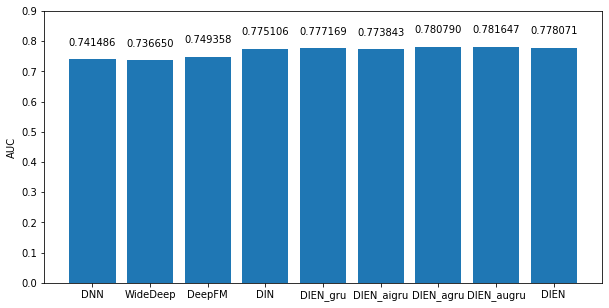

In [49]:
_, ax = plt.subplots(figsize=(10, 5))
rect = ax.bar(list(scores.keys()), list(scores.values()))
ax.set_ylabel('AUC')
ax.set_ylim(top=0.9)
autolabel(rect)
plt.plot()